# 1. Business Understanding

The business understanding for this data science project revolves around analyzing and predicting rent prices across different states and cities in the United States using Zillow's rent dataset from January 2015 to April 2024. The Zillow Rent Index (ZRI) measures changes in asking rents over time, controlling for changes in the quality of available rental stock. By examining this data, you aim to forecast future rent prices for each state and identify the cities that are driving rent prices to extremes, both high and low. This analysis can provide valuable insights for various stakeholders, including real estate investors, property managers, policymakers, and renters. Understanding rent price trends and their geographical variations can help inform investment decisions, guide urban planning policies, and assist individuals in making informed choices about where to live based on affordability. Additionally, this project can shed light on the factors influencing rental market dynamics, such as population growth, economic conditions, and housing supply, which can be crucial for developing strategies to address housing affordability issues in different regions.

In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import ipywidgets as widgets
from IPython.display import display

In [3]:
df = pd.read_csv('melted_dataframe.csv')

In [4]:
# Display first few rows
df.head()

RegionID  SizeRank       RegionName RegionType StateName        Date  \
0    394913         1     New York, NY        msa        NY  2015-01-31   
1    753899         2  Los Angeles, CA        msa        CA  2015-01-31   
2    394463         3      Chicago, IL        msa        IL  2015-01-31   
3    394514         4       Dallas, TX        msa        TX  2015-01-31   
4    394692         5      Houston, TX        msa        TX  2015-01-31   

         Value  
0  2332.141887  
1  1832.730335  
2  1451.965010  
3  1113.846731  
4  1246.658328

# 2. Data Wrangling

There are no missing values ore duplicates for any respective feature.

In [6]:
df.isnull().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
Date          0
Value         0
dtype: int64

In [8]:
# Convert date columns to datetime (if applicable)
df['Date'] = pd.to_datetime(df['Date'])  # Replace with actual date column name


In [9]:
# Check for duplicate rows
df = df.drop_duplicates()

# 3. Exploratory Data Analysis

### 3.1 ADF and PACF

ACF: The Autocorrelation Function shows a significant spike at lag 1, and then the autocorrelations gradually tail off, remaining above the significance band for a number of lags. This slow decay suggests that past values have a persistent influence on the current value.

PACF: The Partial Autocorrelation Function shows significant spikes at lags 1 and potentially 2 (though the spike at lag 2 is smaller and closer to the significance band). After these initial spikes, the partial autocorrelations drop off relatively quickly and fall within the insignificant range.

This pattern is indicative of an Autoregressive (AR) model. The significant spikes in the PACF suggest the order of the AR process. Here, the significant spikes at lags 1 and possibly 2 suggest that an AR(1) or AR(2) model might be appropriate.

The p-value (2.35e-20) is WAY smaller than any common significance level (like 0.05 or even 0.01). We reject the null hypothesis. This provides strong statistical evidence that the "Value" column with respect to time is indeed stationary.

ADF Statistic: -11.192113602456287
p-value: 2.354831663775408e-20
Stationary


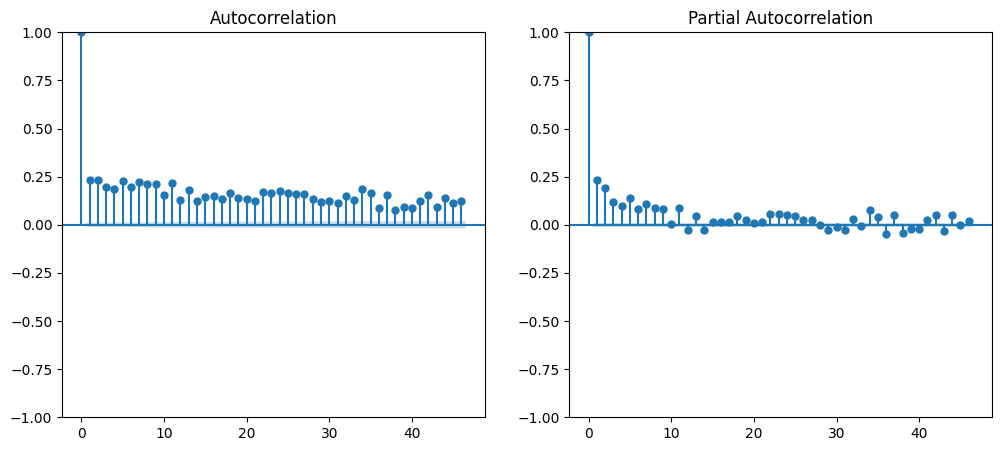

In [11]:
# Check for Stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

adf_test(df['Value'])  # Replace with actual column name

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Value'], ax=ax[0])
plot_pacf(df['Value'], ax=ax[1])
plt.show()

In [ ]:
# Time Series Plot by StateName
fig = px.line(df, x='Date', y='Value', color='StateName',
              title='Time Series by State', labels={'Value': 'Value', 'Date': 'Date'})
fig.show()

In [40]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Load the dataset
df = pd.read_csv('melted_dataframe.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create a dropdown widget for state selection
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

# Function to update plots based on selected state
def update_plots(selected_state):
    # Filter data for the selected state
    last_10_years = df[df['Date'].dt.year >= df['Date'].dt.year.max() - 10]
    state_data = last_10_years[last_10_years['StateName'] == selected_state]

    # Top 5 Regions
    top_regions = state_data.groupby('RegionName')['Value'].mean().nlargest(5).reset_index()
    fig_top = px.bar(top_regions, x='RegionName', y='Value', 
                     title=f"Top 5 Regions Driving Rent Prices in {selected_state}",
                     labels={'Value': 'Average Rent Value', 'RegionName': 'Region'})
    fig_top.show()

    # Bottom 5 Regions
    bottom_regions = state_data.groupby('RegionName')['Value'].mean().nsmallest(5).reset_index()
    fig_bottom = px.bar(bottom_regions, x='RegionName', y='Value', 
                        title=f"Lowest 5 Regions Driving Rent Prices in {selected_state}",
                        labels={'Value': 'Average Rent Value', 'RegionName': 'Region'})
    fig_bottom.show()

# Connect the dropdown to the update function
def on_state_change(change):
    update_plots(change.new)

state_dropdown.observe(on_state_change, names='value')

# Display the dropdown
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

In [41]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Assuming 'df' is your DataFrame and it's already loaded
# If not, load it first:
# df = pd.read_csv('melted_dataframe.csv')
# df['Date'] = pd.to_datetime(df['Date'])

def calculate_rent_stability(df, selected_state):
    """
    Calculates and displays the stability of rent prices for each region within a selected state.
    Stability is measured by the inverse of the coefficient of variation (standard deviation / mean).
    Higher values indicate more stable rent prices.
    """

    state_data = df[df['StateName'] == selected_state].copy()  # Create a copy to avoid modifying the original DataFrame

    # Ensure 'Value' column is numeric
    state_data['Value'] = pd.to_numeric(state_data['Value'], errors='coerce')
    state_data = state_data.dropna(subset=['Value'])  # Remove rows with NaN values in 'Value'

    # Calculate mean and standard deviation for each region
    region_stats = state_data.groupby('RegionName')['Value'].agg(['mean', 'std'])
    region_stats = region_stats.dropna()  # Drop any regions where std is NaN (meaning only one data point)

    # Calculate coefficient of variation
    region_stats['cv'] = region_stats['std'] / region_stats['mean']

    # Calculate stability (inverse of coefficient of variation)
    region_stats['stability'] = 1 / region_stats['cv']

    # Sort by stability
    region_stats = region_stats.sort_values('stability', ascending=False)

    # Display results (Top 10 most stable and Top 10 least stable)
    print(f"Top 10 Most Stable Regions in {selected_state}:")
    print(region_stats.head(10))

    print(f"\nTop 10 Least Stable Regions in {selected_state}:")
    print(region_stats.tail(10))

    # Plotting the stability values
    fig = px.bar(region_stats, x=region_stats.index, y='stability',
                 title=f'Rent Price Stability by Region in {selected_state}',
                 labels={'stability': 'Stability (Inverse of CV)', 'RegionName': 'Region'})
    fig.show()

# Interactive part with dropdown
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

def on_state_change(change):
    calculate_rent_stability(df.copy(), change.new)  # Pass a copy to avoid modifying original

state_dropdown.observe(on_state_change, names='value')
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Assuming 'df' is your DataFrame and it's already loaded
# If not, load it first:
# df = pd.read_csv('melted_dataframe.csv')
# df['Date'] = pd.to_datetime(df['Date'])

def analyze_seasonal_patterns(df, selected_state):
    """
    Analyzes and visualizes seasonal patterns in rent prices for a selected state.
    """

    state_data = df[df['StateName'] == selected_state].copy()

    # Ensure 'Value' column is numeric
    state_data['Value'] = pd.to_numeric(state_data['Value'], errors='coerce')
    state_data = state_data.dropna(subset=['Value'])

    # Group by month and calculate average rent
    state_data['Month'] = state_data['Date'].dt.month
    monthly_avg = state_data.groupby('Month')['Value'].mean().reset_index()

    # Create a line plot of monthly average rent
    fig = px.line(monthly_avg, x='Month', y='Value',
                  title=f'Seasonal Rent Price Patterns in {selected_state}',
                  labels={'Value': 'Average Rent Value', 'Month': 'Month'})

    fig.update_xaxes(tickvals=list(range(1, 13)),
                     ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig.show()

    # Further analysis: Box plots by month to show distribution
    fig_box = px.box(state_data, x='Month', y='Value',
                     title=f'Rent Price Distribution by Month in {selected_state}',
                     labels={'Value': 'Rent Value', 'Month': 'Month'})
    fig_box.update_xaxes(tickvals=list(range(1, 13)),
                     ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig_box.show()



# Interactive part with dropdown
state_options = df['StateName'].unique().tolist()
state_dropdown = widgets.Dropdown(
    options=state_options,
    description='Select State:',
    disabled=False,
)

def on_state_change(change):
    analyze_seasonal_patterns(df.copy(), change.new)  # Pass a copy to avoid modifying original

state_dropdown.observe(on_state_change, names='value')
display(state_dropdown)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

# 4. Time Series Models

Below presents the breakdown of time series analysis per state. For instance for California, the three models produce the following matrices: 

Mean Absolute Error (MAE) for CA: <br>
<br>ARIMA: 613.5557<br>
<br>SARIMA: 802.4721<br>
<br>Prophet: 698.2459<br>

Above scores indicate that ARIMA model performed the best. 

In [14]:
# SARIMA Model
model_sarima = SARIMAX(df['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72786D+00    |proj g|=  6.64928D-02


 This problem is unconstrained.



At iterate    5    f=  7.64651D+00    |proj g|=  6.20582D-03

At iterate   10    f=  7.64101D+00    |proj g|=  1.47582D-03

At iterate   15    f=  7.63517D+00    |proj g|=  1.86303D-02

At iterate   20    f=  7.58442D+00    |proj g|=  1.39628D-01

At iterate   25    f=  7.48323D+00    |proj g|=  8.72018D-03

At iterate   30    f=  7.48314D+00    |proj g|=  1.31467D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   1.315D-05   7.483D+00
  F =   7.4831428582844532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Result

In [15]:
# Prophet Model
df_prophet = df[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

# Plot Prophet Forecast
fig_prophet = plot_plotly(model_prophet, forecast)
fig_prophet.show()


21:05:24 - cmdstanpy - INFO - Chain [1] start processing
21:05:26 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Dictionary to store MAE scores
mae_scores = []

# Forecasting and MAE Calculation by State
def forecast_and_evaluate(state):
    state_df = df[df['StateName'] == state].copy()

    # Ensure at least 24 data points for training (avoid errors)
    if len(state_df) < 24:
        print(f"Skipping {state} due to insufficient data (<24 records).")
        return

    # ARIMA Model
    model_arima = ARIMA(state_df['Value'], order=(1,1,1))
    model_arima_fit = model_arima.fit()
    forecast_arima = model_arima_fit.forecast(steps=12)
    
    # Ensure correct length alignment
    actual_values_arima = state_df['Value'].iloc[-12:].values
    mae_arima = mean_absolute_error(actual_values_arima, forecast_arima[:len(actual_values_arima)])

    # SARIMA Model
    model_sarima = SARIMAX(state_df['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
    model_sarima_fit = model_sarima.fit()
    forecast_sarima = model_sarima_fit.forecast(steps=12)
    
    # Ensure correct length alignment
    actual_values_sarima = state_df['Value'].iloc[-12:].values
    mae_sarima = mean_absolute_error(actual_values_sarima, forecast_sarima[:len(actual_values_sarima)])

    # Prophet Model
    df_prophet = state_df[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    model_prophet = Prophet()
    model_prophet.fit(df_prophet)

    # Generate future dates correctly
    future = model_prophet.make_future_dataframe(periods=12, freq='M')
    forecast_prophet = model_prophet.predict(future)
    forecast_prophet_values = forecast_prophet[['ds', 'yhat']].tail(12)

    # Align actual and forecasted values for MAE calculation
    actual_values_prophet = state_df[state_df['Date'].isin(forecast_prophet_values['ds'])]['Value']
    
    # Ensure correct length alignment
    if len(actual_values_prophet) == len(forecast_prophet_values):
        mae_prophet = mean_absolute_error(actual_values_prophet, forecast_prophet_values['yhat'])
    else:
        actual_values_prophet = state_df['Value'].iloc[-12:]  # Fallback to last 12 known values
        mae_prophet = mean_absolute_error(actual_values_prophet, forecast_prophet_values['yhat'])

    # Store MAE scores
    mae_scores.append({'State': state, 'MAE_ARIMA': mae_arima, 'MAE_SARIMA': mae_sarima, 'MAE_Prophet': mae_prophet})

    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=state_df['Date'], y=state_df['Value'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=state_df['Date'].iloc[-1], periods=12, freq='M'), 
                             y=forecast_arima, mode='lines', name='ARIMA Forecast'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=state_df['Date'].iloc[-1], periods=12, freq='M'), 
                             y=forecast_sarima, mode='lines', name='SARIMA Forecast'))
    fig.add_trace(go.Scatter(x=forecast_prophet_values['ds'], y=forecast_prophet_values['yhat'], 
                             mode='lines', name='Prophet Forecast'))
    fig.update_layout(title=f'12-Month Forecast for {state}', xaxis_title='Date', yaxis_title='Value')
    fig.show()

    # Display MAE Scores
    print(f"Mean Absolute Error (MAE) for {state}:")
    print(f"ARIMA: {mae_arima:.4f}")
    print(f"SARIMA: {mae_sarima:.4f}")
    print(f"Prophet: {mae_prophet:.4f}")

# Dropdown Menu for State Selection
states = df['StateName'].unique()
dropdown = widgets.Dropdown(options=states, description='Select State:', continuous_update=False)
output = widgets.Output()

def on_state_change(change):
    if change['new']:
        output.clear_output(wait=True)
        with output:
            forecast_and_evaluate(change['new'])

dropdown.observe(on_state_change, names='value')
display(dropdown, output)

# Plot MAE scores for all states
def plot_mae_scores():
    mae_df = pd.DataFrame(mae_scores)
    if not mae_df.empty:
        fig = px.bar(mae_df.melt(id_vars=['State'], var_name='Model', value_name='MAE'),
                     x='State', y='MAE', color='Model',
                     title='MAE Scores for ARIMA, SARIMA, and Prophet by State')
        fig.show()

# Button to display MAE chart
mae_button = widgets.Button(description="Show MAE Chart")
mae_output = widgets.Output()

def on_mae_button_click(b):
    mae_output.clear_output(wait=True)
    with mae_output:
        plot_mae_scores()

mae_button.on_click(on_mae_button_click)
display(mae_button, mae_output)


Dropdown(description='Select State:', options=('NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI…

Output()

Button(description='Show MAE Chart', style=ButtonStyle())

Output()

#### Time Series Analysis - All States 

In [35]:
# Time Series Plot
fig = px.line(df, x='Date', y='Value', title='Time Series Analysis', labels={'Value': 'Value', 'Date': 'Date'})
fig.show()

# National-Level Forecasting
df_national = df.groupby('Date').agg({'Value': 'sum'}).reset_index()

# ARIMA for National-Level Forecast
model_arima_national = ARIMA(df_national['Value'], order=(1,1,1))
model_arima_national_fit = model_arima_national.fit()
national_forecast_arima = model_arima_national_fit.forecast(steps=12)
mae_arima_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_arima)

# SARIMA for National-Level Forecast
model_sarima_national = SARIMAX(df_national['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_national_fit = model_sarima_national.fit()
national_forecast_sarima = model_sarima_national_fit.forecast(steps=12)
mae_sarima_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_sarima)

# Prophet for National-Level Forecast
df_prophet_national = df_national.rename(columns={'Date': 'ds', 'Value': 'y'})
model_prophet_national = Prophet()
model_prophet_national.fit(df_prophet_national)
national_future = model_prophet_national.make_future_dataframe(periods=12, freq='M')
national_forecast_prophet = model_prophet_national.predict(national_future)
national_forecast_prophet_values = national_forecast_prophet[['ds', 'yhat']].tail(12)
mae_prophet_national = mean_absolute_error(df_national['Value'][-12:], national_forecast_prophet_values['yhat'])

# Plot National-Level Forecast using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_national['Date'], y=df_national['Value'], mode='lines+markers', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=pd.date_range(start=df_national['Date'].iloc[-1], periods=12, freq='M'), y=national_forecast_arima, mode='lines+markers', name='ARIMA Forecast', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=pd.date_range(start=df_national['Date'].iloc[-1], periods=12, freq='M'), y=national_forecast_sarima, mode='lines+markers', name='SARIMA Forecast', line=dict(color='green', dash='dot')))
fig.add_trace(go.Scatter(x=national_forecast_prophet_values['ds'], y=national_forecast_prophet_values['yhat'], mode='lines+markers', name='Prophet Forecast', line=dict(color='purple', dash='longdash')))
fig.update_layout(title='12-Month National-Level Forecast', xaxis_title='Date', yaxis_title='Value', template='plotly_white')
fig.show()

# Display MAE Scores
print("Mean Absolute Error (MAE) for National-Level Forecast:")
print(f"ARIMA: {mae_arima_national:.4f}")
print(f"SARIMA: {mae_sarima_national:.4f}")
print(f"Prophet: {mae_prophet_national:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83170D+00    |proj g|=  1.18562D+00

At iterate    5    f=  9.27242D+00    |proj g|=  2.29146D-02

At iterate   10    f=  9.27178D+00    |proj g|=  7.88333D-02

At iterate   15    f=  9.26921D+00    |proj g|=  4.63832D-03

At iterate   20    f=  9.26054D+00    |proj g|=  1.22898D-02

At iterate   25    f=  9.24700D+00    |proj g|=  1.04718D-03

At iterate   30    f=  9.24432D+00    |proj g|=  2.13076D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     54      1     0     0   2.436D-03   9.244D+00
  F =   9.2441956246676487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Mean Absolute Error (MAE) for National-Level Forecast:
ARIMA: 186850.0363
SARIMA: 278736.9069
Prophet: 144211.9065


# 5. Final Summary